# Feature Plot 

To Do 
- add legend for Transgene with gradient and error (position in reference)
- squish a bit 

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

from Bio import SeqIO
from collections import defaultdict, OrderedDict

## Parse files

Parse the genbank file

In [2]:
# Replace 'your_genbank_file.gbk' with the path to your GenBank file
genbank_file = '00-Data/feature_annotated/Repeatmasker_transgene_classified_merged.gb'

# Parse the GenBank file
records = list(SeqIO.parse(genbank_file, 'genbank'))

new_record_list = []
allowed_category_list = ["SNAPBACK", "DUPLICATION_ROI", "RANDOM_INSERT"]
# allowed_category_list = ["COMPLETE"]

for record in records:
    record_id = record.id
    record_category = record_id.split("-", 1)[0]
    if record_category in allowed_category_list:
        new_record_list.append(record)

Parse the reference fasta go get the feature length

In [3]:
### Fetch Reference Segments 
ref_fasta_path = "00-Data/references/ref_28s_features.fasta"

feature_range_dict = OrderedDict()

running_total = 0
for record in SeqIO.parse(ref_fasta_path, "fasta"):
    record_length = len(record.seq)
    feature_range_dict[record.id] = {
        "start": running_total,
        "end": running_total + record_length,
        "length" : record_length
    }
    running_total += record_length


reference_length = running_total
print("Total length of reference:", reference_length)

Total length of reference: 2302


## Plot the Feature Annotation Plot

Custom arrow with gradient

In [4]:
def hex_to_rgb(hex_color):
    """Convert #RRGGBB to (r, g, b) in [0,1]."""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4))

def lighten_color(rgb, factor=1.5):
    """Lighten an RGB color by the given factor."""
    return tuple(min(1.0, c*factor) for c in rgb)

def color_at(t, color_scale_start, color_scale_end):
    """Return an interpolated color for t in [0,1]."""
    return (
        color_scale_start[0] + t*(color_scale_end[0] - color_scale_start[0]),
        color_scale_start[1] + t*(color_scale_end[1] - color_scale_start[1]),
        color_scale_start[2] + t*(color_scale_end[2] - color_scale_start[2]),
    )

def plot_gradient_arrow(ax, line_position, colour_range, color_hex='#9CC593', lighten_factor=1.5, arrow_args={}):
    """Plot a gradient arrow on the given axis.
    Line position is a tuple (x_start, x_end, y) defining the position of the line.
    Colour range is a tuple (color_start, color_end) defining the start and end colors of the gradient.
    color_hex is the base color of the arrow fill.
    lighten_factor is the factor by which the base color is lightened to create the arrow fill, values > 1 lighten the color.
    
    """
    # Get the line position and color range
    x_start, x_end, y = line_position
    color_min, color_max = colour_range

    # Calculate the gradient based on a hex value
    color_scale_start = hex_to_rgb(color_hex)
    color_scale_end = lighten_color(color_scale_start, lighten_factor)
    color_scale = np.linspace(color_scale_start, color_scale_end, 1000 + 1)

    color_start = color_at(color_min, color_scale_start, color_scale_end) 
    color_end = color_at(color_max, color_scale_start, color_scale_end)

    # Number of segments in the gradient (e.g. 5 would be very blocky, 256 is smoother)
    N = 256
    r_vals = np.linspace(color_start[0], color_end[0], N)
    g_vals = np.linspace(color_start[1], color_end[1], N)
    b_vals = np.linspace(color_start[2], color_end[2], N)
    
    grad_colors = np.dstack((r_vals, g_vals, b_vals, np.ones(N))).reshape(1, N, 4)

    c_extent = [x_start, x_end, y - 0.5, y + 0.5]
    
    # Plot the gradient rectangle
    ax.imshow(grad_colors, extent=c_extent, aspect='auto')
    
    # Plot the arrow
    arrow = ax.arrow(x_start, y, x_end - x_start, 0, fill=False, **arrow_args)
    ax.add_patch(arrow)

    # Clip the rectangle to arrow shape
    ax.images[-1].set_clip_path(arrow)

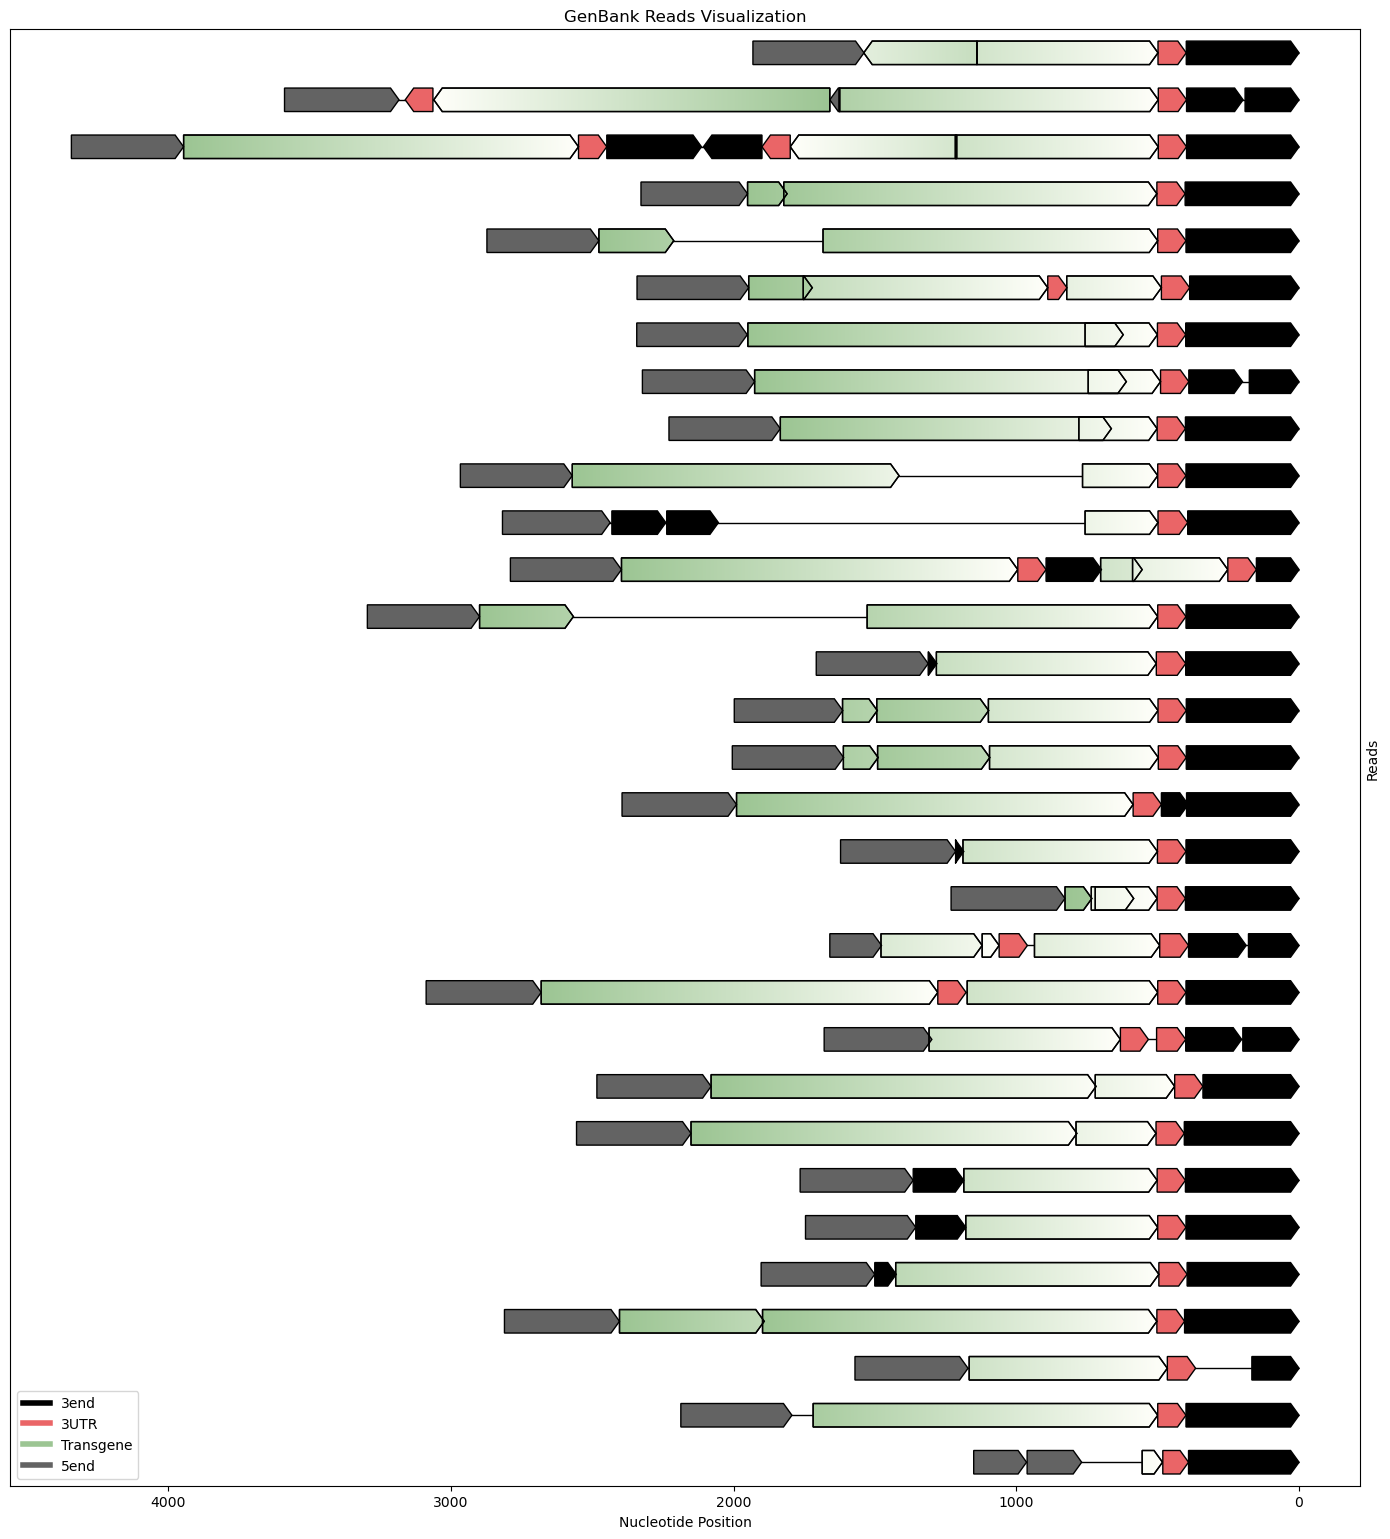

In [5]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(14, len(new_record_list)*0.5))

# Define colors for different feature types (optional)
feature_colors = {
    "3end": "#000000",
    "3UTR": "#EA6567",
    "Transgene": "#9cc593",
    "5end": "#636363",
}

# This style is applied to all arrows
arrow_style = {
    "width": 0.5,
    "head_width": 0.5,
    "head_length": 30,
    # "head_starts_at_zero": True,
    "length_includes_head": True
}

# Plot each record
for i, record in enumerate(new_record_list):
    y_position = len(new_record_list) - i  # So that the first record is at the top

    # Get the length of the record
    record_length = len(record.seq)

    # Plot the full length of the read as a horizontal black line
    ax.hlines(y=y_position, xmin=0, xmax=len(record.seq), color='black', linewidth=1, zorder=0)

    # Annotate features on the read
    for feature in record.features:
        feature_type = feature.type

        if feature_type in feature_colors:
            start = record_length - int(feature.location.start)
            end = record_length - int(feature.location.end)

            # Reverse start und end for reverse strand features
            if feature.location.strand == -1:
                start, end = end, start
            
            # ax.hlines(y=y_position, xmin=start, xmax=end, color=feature_colors[feature_type], linewidth=4)
            # For feature type "Transgene" we use a gradient arrow, for all other types a simple arrow
            if feature_type == "Transgene":
                # Get reference positions
                ref_start = int(feature.qualifiers["ref_position_start"][0])
                ref_end = int(feature.qualifiers["ref_position_end"][0])

                # Calculate the color range based on the reference positions
                colour_range_start = ref_start / feature_range_dict[feature_type]['length']
                colour_range_end = ref_end / feature_range_dict[feature_type]['length'] 

                plot_gradient_arrow(ax, 
                                    (start, end, y_position),
                                    (colour_range_start, colour_range_end),
                                    color_hex=feature_colors[feature_type],
                                    lighten_factor=1.7,
                                    arrow_args=arrow_style
                )
            else:
                ax.arrow(start, y_position, end-start, 0, fc=feature_colors[feature_type], ec="black", **arrow_style)

    # Add the record ID to the left of the line
    # ax.text(-0.02 * len(record.seq), y_position, record.id, va='center', ha='right', fontsize=8)

# Configure the plot
ax.set_xlabel('Nucleotide Position')
ax.set_ylabel('Reads')
ax.set_title('GenBank Reads Visualization')
ax.set_yticks([])  # Hide y-axis ticks since we have labels
ax.set_xlim(-0.05 * max(len(r.seq) for r in new_record_list), max(len(r.seq) for r in new_record_list) * 1.05)
ax.set_ylim(0.5, len(new_record_list) + 0.5)
ax.xaxis.set_inverted(True)

# Move the y-axis to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# Add a legend for feature types
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=color, lw=4, label=ftype) for ftype, color in feature_colors.items()]
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.savefig("04-Feature-Plot.pdf")
plt.show()

## Arrow for legend

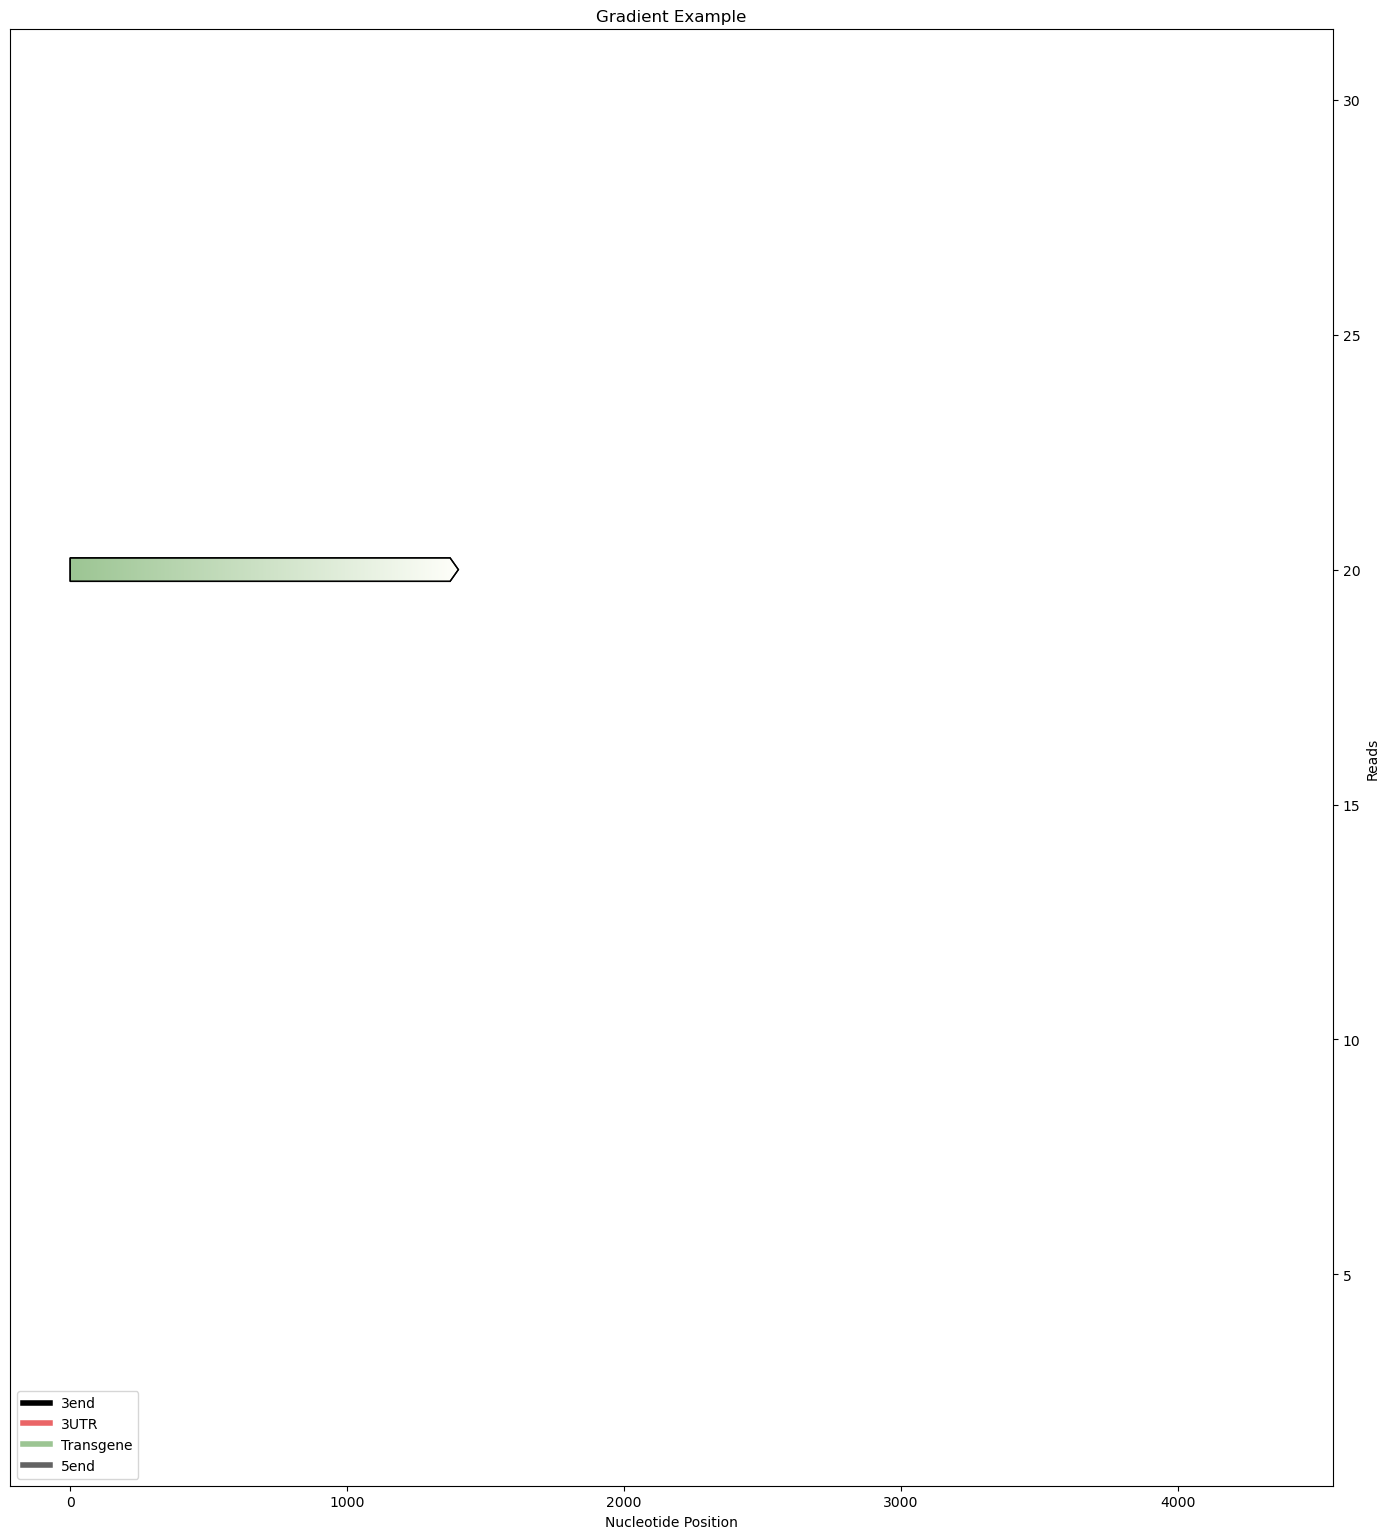

In [6]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(14, len(new_record_list)*0.5))

# Define colors for different feature types (optional)
feature_colors = {
    "3end": "#000000",
    "3UTR": "#EA6567",
    "Transgene": "#9cc593",
    "5end": "#636363",
}

# Define Arrow Position
start = 0
end = 1402
y_position = 20

# Colour range [0,1]
colour_range_start = 0
colour_range_end = 1
feature_type = "Transgene"

plot_gradient_arrow(ax, 
                    (start, end, y_position),
                    (colour_range_start, colour_range_end),
                    color_hex=feature_colors[feature_type],
                    lighten_factor=1.7,
                    arrow_args=arrow_style
)


# Configure the plot
ax.set_xlabel('Nucleotide Position')
ax.set_ylabel('Reads')
ax.set_title('Gradient Example')
ax.set_xlim(-0.05 * max(len(r.seq) for r in new_record_list), max(len(r.seq) for r in new_record_list) * 1.05)
ax.set_ylim(0.5, len(new_record_list) + 0.5)
# ax.xaxis.set_inverted(True)

# Move the y-axis to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# Add a legend for feature types
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=color, lw=4, label=ftype) for ftype, color in feature_colors.items()]
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.savefig("arrow.pdf")
plt.show()